In [2]:
# !pip install transformers[torch]

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 2.8 MB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 625 kB/s  eta 0:00:01
     |████████████████████████████████| 745 kB 72.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 63.5 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 1.3 kB/s  eta 0:00:01█▉                          | 152.0 MB 21.5 MB/s eta 0:00:32     |██████████████▍                 | 373.3 MB 88.9 MB/s eta 0:00:06     |████████████████▉               | 438.2 MB

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [61]:
torch.__version__

'1.9.0+cu102'

In [62]:
df = pd.read_csv('../data/amazon_reviews_small.csv')

In [63]:
df['review'] = df['review_headline'] + '. ' + df['review_body']

In [64]:
df['review_sentiments'] = 0

In [65]:
df['review_sentiments'][df['star_rating'].isin([4, 5])] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
df = df.drop(columns=['Unnamed: 0', 'review_headline', 'review_body', 'star_rating'])

In [67]:
df

,review,review_sentiments
0,Good book. This is a very good book. I recomme...,1
1,the Marenon Chronically Series. Loved all thre...,1
2,GOOD READ. Made me think about the fine line b...,1
3,excellant family devotion. I had been looking ...,1
4,"Great read. So entertaining, not a dull moment...",1
...,...,...
9995,Awesome. I haven't read a book like this in a ...,1
9996,Absolutely GREAT. I started reading it because...,1
9997,Sicko. These are two writers with some serious...,0
9998,Just too small. It was just too small for the ...,0


In [68]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [69]:
df_small = stratified_sample_df(df, 'review_sentiments', 1000)

In [70]:
df_small['review_sentiments'].value_counts()

1    1000
0    1000
Name: review_sentiments, dtype: int64

In [71]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_small['review'], 
                                                                    df_small['review_sentiments'], 
                                                                    stratify=df_small['review_sentiments'], 
                                                                    test_size=0.5, 
                                                                    random_state=42)

In [72]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, 
                                                                temp_labels, 
                                                                stratify=temp_labels, 
                                                                test_size=500, 
                                                                random_state=42)

In [73]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


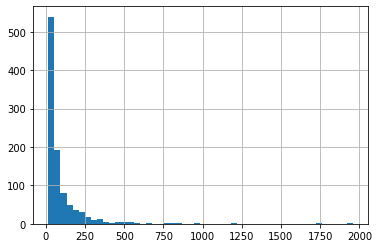

In [74]:
seq_len = [len(i.split()) for i in train_text]
import matplotlib.pyplot as plt
pd.Series(seq_len).hist(bins = 50)
plt.show()

In [75]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 100,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 100,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 100,
    padding=True,
    truncation=True
)

In [76]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [77]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [78]:
# freeze all the parameter
for param in bert.parameters():
    param.requires_grad = False

In [79]:
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        
        super(BERT_Arch, self).__init__()
        
        self.bert = bert
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # relu activation function
        self.relu =  nn.ReLU()
        
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
        
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
        
    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)
        
        x = self.relu(x)
        
        x = self.dropout(x)
        
        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)
        
        return x

In [80]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# push the model to CPU
model = model.to(device)

Using cpu device


In [81]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [82]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [83]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)

weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [84]:
# function to train the model
def train():
    
    model.train()
    
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 10 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
            
        # push the batch to device
        batch = [r.to(device) for r in batch]  
        sent_id, mask, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
            
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
        
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
        
    #returns the loss and predictions
    return avg_loss, total_preds

In [85]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []
    
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 10 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            # elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
            
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        
        sent_id, mask, labels = batch
        
        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)
            
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            
            total_loss = total_loss + loss.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [86]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    10  of     32.
  Batch    20  of     32.
  Batch    30  of     32.

Evaluating...
  Batch    10  of     16.

Training Loss: 0.762
Validation Loss: 0.661

 Epoch 2 / 10
  Batch    10  of     32.
  Batch    20  of     32.
  Batch    30  of     32.

Evaluating...
  Batch    10  of     16.

Training Loss: 0.643
Validation Loss: 0.613

 Epoch 3 / 10
  Batch    10  of     32.
  Batch    20  of     32.
  Batch    30  of     32.

Evaluating...
  Batch    10  of     16.

Training Loss: 0.629
Validation Loss: 0.572

 Epoch 4 / 10
  Batch    10  of     32.
  Batch    20  of     32.
  Batch    30  of     32.

Evaluating...
  Batch    10  of     16.

Training Loss: 0.571
Validation Loss: 0.537

 Epoch 5 / 10
  Batch    10  of     32.
  Batch    20  of     32.
  Batch    30  of     32.

Evaluating...
  Batch    10  of     16.

Training Loss: 0.550
Validation Loss: 0.517

 Epoch 6 / 10
  Batch    10  of     32.
  Batch    20  of     32.
  Batch    30  of     32.

Evaluating.

In [87]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [2]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

NameError: name 'torch' is not defined

In [1]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

NameError: name 'np' is not defined

In [114]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,193,57
1,63,187


In [2]:
train_seq

NameError: name 'train_seq' is not defined